# EXP06: Normalization & Typed-Cut Enhancement
**목표**: 답변 정규화 파이프라인 + 질문 유형별 컷 정책 + 3-run 평균화 프로토콜

### EXP05 핵심 교훈
- GENERATION_MISS 6건 중 5건(83%)이 표현 불일치 → **정규화가 최고 ROI**
- Elbow 동적 컷이 +5.5%p 개선 → **CONTEXT_NOISE 패턴 존재 확인**
- 단일 실행 변동폭 -9.5%p → **3-run 평균화 필수**

### 실험 구조
| Phase | 내용 | 목적 |
|-------|------|------|
| Phase 0 | Enhanced 5-class 포렌식 | CONTEXT_NOISE 분류 추가 |
| Phase 1 | 정규화 ON/OFF × Config | KW_Acc 측정 개선 |
| Phase 2 | 질문 유형별 컷 정책 | 테이블/텍스트 최적화 |
| Phase 3 | 통합 검증 (3-run) | 최종 성능 + 신뢰구간 |

### 목표 지표 (3-run 평균 기준)
| Metric | EXP04-v3 | EXP05 best | EXP06 목표 |
|--------|----------|------------|-----------|
| KW_Acc | 0.741 | 0.706 | ≥ 0.80 |
| KW_Acc_norm | - | - | ≥ 0.85 |
| CR | 0.900 | 0.800 | ≥ 0.90 |
| Faithfulness | 0.922 | 0.836 | ≥ 0.90 |

In [2]:
# ============================================================
# 1. Setup
# ============================================================
import os
import re
import gc
import json
import time
import shutil
import hashlib
import warnings
from datetime import datetime
from collections import defaultdict

from dotenv import load_dotenv
load_dotenv()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber
import torch

from datasets import Dataset
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever

from ragas import evaluate
from ragas.metrics import Faithfulness, ContextRecall
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

from sentence_transformers import CrossEncoder

from bidflow.parsing.preprocessor import TextPreprocessor
from bidflow.eval.ragas_runner import FixedTempChatOpenAI

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f'[GPU] {gpu_name} ({gpu_mem:.1f} GB VRAM)')
else:
    print('[CPU] GPU not available')
print(f'[Device] {DEVICE}')
print('[OK] Setup complete')

[GPU] NVIDIA GeForce RTX 4080 SUPER (16.0 GB VRAM)
[Device] cuda
[OK] Setup complete


C:\Users\c\AppData\Local\Temp\ipykernel_52092\3645877501.py:34: DeprecationWarning: Importing Faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import Faithfulness
  from ragas.metrics import Faithfulness, ContextRecall
C:\Users\c\AppData\Local\Temp\ipykernel_52092\3645877501.py:34: DeprecationWarning: Importing ContextRecall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ContextRecall
  from ragas.metrics import Faithfulness, ContextRecall


In [3]:
# ============================================================
# 2. Config & Data Load
# ============================================================
EXP04_REPORT_PATH = '../data/experiments/exp04_report.json'
EXP05_FORENSIC_PATH = '../data/experiments/exp05_forensic.json'
GOLDEN_TESTSET_PATH = '../data/experiments/golden_testset.csv'
CHROMA_BASE_PATH = '../data/chroma_exp/exp06'

OUT_FORENSIC_PATH = '../data/experiments/exp06_forensic.json'
OUT_REPORT_PATH = '../data/experiments/exp06_report.json'
OUT_CSV_PATH = '../data/experiments/exp06_results.csv'
OUT_FIG_PATH = '../data/experiments/exp06_results.png'
INTERMEDIATE_PATH = '../data/experiments/exp06_intermediate.json'

EMBED_MODEL = 'text-embedding-3-small'
GEN_MODEL = 'gpt-5-mini'
RERANKER_MODEL = 'BAAI/bge-reranker-v2-m3'

ALPHA = 0.7
RERANK_POOL = 50
TOP_K = 15
N_RUNS = 3  # 다중 실행 프로토콜

print('=' * 60)
print('EXP06: Normalization & Typed-Cut Enhancement')
print('=' * 60)

with open(EXP04_REPORT_PATH, 'r', encoding='utf-8') as f:
    exp04 = json.load(f)
FACT_SHEET_DATA = exp04['meta']['fact_sheet']
SAMPLE_FILE = exp04['meta']['sample_file']
fact_lines = [f'- {k}: {v}' for k, v in FACT_SHEET_DATA.items() if v and v != '확인불가']
FACT_SHEET = '\n'.join(fact_lines)

# EXP05 포렌식 로드 (비교용)
with open(EXP05_FORENSIC_PATH, 'r', encoding='utf-8') as f:
    exp05_forensic = json.load(f)

golden_df = pd.read_csv(GOLDEN_TESTSET_PATH)
golden_df = golden_df[golden_df['question'].notna() & (golden_df['question'] != '')]
golden_df = golden_df[~golden_df['ground_truth'].str.contains(r'\[여기에', na=False)]
golden_df = golden_df.reset_index(drop=True)

print(f'  Baseline: EXP04-v3 (KW=0.741, CR=0.900, Faith=0.922)')
print(f'  Test cases: {len(golden_df)}')
print(f'  Multi-run: N={N_RUNS}')
print(f'  Fixed: reranker@{RERANK_POOL}, \u03b1={ALPHA}')

EXP06: Normalization & Typed-Cut Enhancement
  Baseline: EXP04-v3 (KW=0.741, CR=0.900, Faith=0.922)
  Test cases: 30
  Multi-run: N=3
  Fixed: reranker@50, α=0.7


In [4]:
# ============================================================
# 3. Helper Functions (Enhanced from EXP05)
# ============================================================

def robust_rmtree(path):
    if not os.path.exists(path): return
    for _ in range(5):
        try: shutil.rmtree(path); return
        except PermissionError: gc.collect(); time.sleep(1)
        except Exception: return


def table_to_markdown(table_data):
    if not table_data or len(table_data) < 1:
        return ''
    max_cols = max(len(row) for row in table_data)
    rows = []
    for row in table_data:
        clean = []
        for cell in row:
            c = str(cell).strip().replace('\n', ' ').replace('|', '/') if cell else ''
            clean.append(c if c != 'None' else '')
        while len(clean) < max_cols:
            clean.append('')
        rows.append(clean)
    if all(all(c == '' for c in row) for row in rows):
        return ''
    lines = []
    lines.append('| ' + ' | '.join(rows[0]) + ' |')
    lines.append('| ' + ' | '.join(['---'] * max_cols) + ' |')
    for row in rows[1:]:
        lines.append('| ' + ' | '.join(row) + ' |')
    return '\n'.join(lines)


def rrf_merge(bm25_docs, vec_docs, w_bm25=0.3, w_vec=0.7, top_k=15, k=60):
    scores = defaultdict(float)
    doc_map = {}
    for rank, doc in enumerate(bm25_docs):
        scores[doc.page_content] += w_bm25 * (1 / (rank + k))
        doc_map[doc.page_content] = doc
    for rank, doc in enumerate(vec_docs):
        scores[doc.page_content] += w_vec * (1 / (rank + k))
        if doc.page_content not in doc_map:
            doc_map[doc.page_content] = doc
    sorted_contents = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[c] for c in sorted_contents[:top_k]]


# ──────────────────────────────────────────────────────
# 정규화 v1 (EXP05 기존)
# ──────────────────────────────────────────────────────
def normalize_answer_v1(text):
    if not isinstance(text, str):
        return str(text).strip().lower()
    t = text.strip().lower()
    t = re.sub(r'(\d),(?=\d{3})', r'\1', t)
    t = re.sub(r'(\d+)\s*(%|퍼센트|percent)', r'\1%', t)
    t = re.sub(r'(\d+)\s*학년도', r'\1', t)
    t = re.sub(r'(\d+)\s*원', r'\1원', t)
    t = re.sub(r'\s+', ' ', t)
    return t


# ──────────────────────────────────────────────────────
# 정규화 v2 (EXP06 강화)
# ──────────────────────────────────────────────────────
SYNONYM_MAP = {
    '통합로그인': 'sso', '단일 로그인': 'sso', '싱글사인온': 'sso',
    '간편인증': '간편인증', '간편 인증': '간편인증',
    '2차인증': '2차인증', '2차 인증': '2차인증', '추가인증': '2차인증',
    'project manager': 'pm', '사업관리자': 'pm', '사업책임자': 'pm', '프로젝트 매니저': 'pm',
    'project leader': 'pl', '프로젝트 리더': 'pl',
    'quality assurance': 'qa', '품질관리': 'qa', '품질보증': 'qa',
    '하자보수': '하자보수', '하자 보수': '하자보수',
    '발주처': '발주기관', '발주 기관': '발주기관',
}

def normalize_answer_v2(text):
    if not isinstance(text, str):
        return str(text).strip().lower()
    t = text.strip().lower()
    # 1. 구두점 정리
    t = re.sub(r'[\u00b7\u2027\u2022\u2219]', ' ', t)
    t = re.sub(r'[\u201c\u201d\u2018\u2019\u300c\u300d\u300e\u300f]', '', t)
    t = re.sub(r'[-\u2013\u2014]', ' ', t)
    # 2. 숫자 콤마 제거
    t = re.sub(r'(\d),(?=\d{3})', r'\1', t)
    # 3. 비율 통일
    t = re.sub(r'(\d+)\s*(%|퍼센트|percent)', r'\1%', t)
    # 4. 통화 정리
    t = re.sub(r'(\d+)\s*원', r'\1원', t)
    t = re.sub(r'(\d+)\s*억\s*원', r'\1억원', t)
    t = re.sub(r'(\d+)\s*만\s*원', r'\1만원', t)
    # 5. VAT 통일
    t = t.replace('v.a.t', 'vat').replace('vat 포함', 'vat포함')
    # 6. 동의어 치환
    for orig, norm in SYNONYM_MAP.items():
        t = t.replace(orig.lower(), norm)
    # 7. 공백 정리
    t = re.sub(r'\s+', ' ', t).strip()
    return t


def keyword_accuracy(answer, ground_truth):
    gt_words = [w for w in ground_truth.lower().split() if len(w) > 1]
    if not gt_words: return 1.0
    matched = sum(1 for w in gt_words if w in answer.lower())
    return matched / len(gt_words)


def keyword_accuracy_norm_v1(answer, ground_truth):
    ans_norm = normalize_answer_v1(answer)
    gt_norm = normalize_answer_v1(ground_truth)
    gt_words = [w for w in gt_norm.split() if len(w) > 1]
    if not gt_words: return 1.0
    matched = sum(1 for w in gt_words if w in ans_norm)
    return matched / len(gt_words)


def keyword_accuracy_norm_v2(answer, ground_truth):
    ans_norm = normalize_answer_v2(answer)
    gt_norm = normalize_answer_v2(ground_truth)
    gt_words = [w for w in gt_norm.split() if len(w) > 1]
    if not gt_words: return 1.0
    matched = sum(1 for w in gt_words if w in ans_norm)
    return matched / len(gt_words)


def classify_question_domain(row):
    cat = str(row.get('category', '')).lower()
    gt = str(row.get('ground_truth', '')).lower()
    q = str(row.get('question', '')).lower()
    table_cats = {'budget', 'evaluation', 'schedule'}
    table_keywords = ['비율', '배점', '금액', '예산', '지급', '연도별', '기간']
    if cat in table_cats: return 'table'
    if any(kw in q or kw in gt for kw in table_keywords): return 'table'
    return 'text'


def is_table_signal(question):
    signals = ['비율', '배점', '금액', '예산', '지급', '연도별', '기간',
               '얼마', '몇', '%', '퍼센트', '원', '억', '만원',
               '연도', '단가', '산정', '배분', '총액']
    return any(s in question.lower() for s in signals)


def detect_question_type(question):
    table_signals = ['비율', '배점', '금액', '예산', '지급', '연도별', '기간',
                     '얼마', '몇', '%', '퍼센트', '원', '억', '만원',
                     '연도', '단가', '산정', '배분', '총액', '점수', '평가표']
    return 'table' if any(s in question for s in table_signals) else 'text'


def retrieve_pool(query, bm25_retriever, vec_db, pool_size=50):
    bm25_retriever.k = pool_size * 2
    bm25_r = bm25_retriever.invoke(query)
    vec_r = vec_db.as_retriever(search_kwargs={"k": pool_size * 2}).invoke(query)
    return rrf_merge(bm25_r, vec_r, w_bm25=1-ALPHA, w_vec=ALPHA, top_k=pool_size)


def rerank_docs(query, pool_docs, reranker, top_n=15):
    if not pool_docs: return [], []
    pairs = [(query, doc.page_content) for doc in pool_docs]
    scores = reranker.predict(pairs)
    ranked = sorted(zip(pool_docs, scores), key=lambda x: x[1], reverse=True)
    return [d for d, s in ranked[:top_n]], [s for d, s in ranked]


def rerank_with_elbow_cut(query, pool_docs, reranker, max_n=15, min_n=5):
    if not pool_docs: return [], []
    pairs = [(query, doc.page_content) for doc in pool_docs]
    scores = reranker.predict(pairs)
    ranked = sorted(zip(pool_docs, scores), key=lambda x: x[1], reverse=True)
    sorted_scores = [s for _, s in ranked]
    cut_idx = max_n
    if len(sorted_scores) >= min_n + 1:
        deltas = [sorted_scores[i] - sorted_scores[i+1]
                  for i in range(min(max_n-1, len(sorted_scores)-1))]
        if deltas:
            max_delta_idx = max(range(len(deltas)), key=lambda i: deltas[i])
            candidate = max_delta_idx + 1
            if candidate >= min_n:
                cut_idx = candidate
    cut_idx = max(min_n, min(cut_idx, max_n, len(ranked)))
    return [d for d, s in ranked[:cut_idx]], sorted_scores


def rerank_with_typed_cut(query, pool_docs, reranker, question_type='text'):
    if question_type == 'table':
        return rerank_with_elbow_cut(query, pool_docs, reranker, max_n=15, min_n=8)
    else:
        return rerank_with_elbow_cut(query, pool_docs, reranker, max_n=12, min_n=3)


def classify_failure_v2(oracle_found, pool_kw_found, final_kw_found,
                        kw_acc, table_ratio, context_size):
    if not oracle_found:
        return 'INDEX_MISSING'
    if not pool_kw_found:
        return 'RETRIEVAL_MISS'
    if not final_kw_found:
        return 'RERANK_MISS'
    if kw_acc < 0.5 and table_ratio > 0.4:
        return 'CONTEXT_NOISE'
    if kw_acc < 0.5:
        return 'GENERATION_MISS'
    return 'OK'


def run_ragas_eval(per_question, ragas_llm, ragas_emb):
    eval_dict = {
        'user_input': [pq['question'] for pq in per_question],
        'response': [pq['answer'] for pq in per_question],
        'retrieved_contexts': [pq['retrieved_contexts'] for pq in per_question],
        'reference': [pq['ground_truth'] for pq in per_question],
    }
    hf_dataset = Dataset.from_dict(eval_dict)
    metrics = [Faithfulness(llm=ragas_llm), ContextRecall(llm=ragas_llm)]
    result = evaluate(dataset=hf_dataset, metrics=metrics,
                      llm=ragas_llm, embeddings=ragas_emb, raise_exceptions=False)
    return result.to_pandas()


print('[OK] Helpers ready (v2: normalize_v2, typed_cut, 5-class)')

[OK] Helpers ready (v2: normalize_v2, typed_cut, 5-class)


In [5]:
# ============================================================
# 4. PDF Parsing & Baseline Index 구축
# ============================================================
preprocessor = TextPreprocessor()

with pdfplumber.open(SAMPLE_FILE) as pdf:
    page_texts = []
    page_tables_raw = []
    for i, page in enumerate(pdf.pages):
        raw_text = page.extract_text(layout=True) or ''
        norm = preprocessor.normalize(raw_text)
        page_texts.append((i + 1, norm))
        tables = page.extract_tables() or []
        page_tables_raw.append((i + 1, tables))

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50,
                                           separators=['\n\n', '\n', '. ', ' '])
baseline_docs = []
chunk_id = 0
for page_no, text in page_texts:
    chunks = splitter.split_text(text)
    for ci, chunk in enumerate(chunks):
        baseline_docs.append(Document(
            page_content=chunk,
            metadata={'chunk_id': chunk_id, 'page': page_no,
                      'content_type': 'text', 'source': 'exp06'}
        ))
        chunk_id += 1

for page_no, tables in page_tables_raw:
    for ti, table_data in enumerate(tables):
        md_table = table_to_markdown(table_data)
        if md_table and len(md_table) > 20:
            baseline_docs.append(Document(
                page_content=f'[표 {page_no}-{ti+1}]\n{md_table}',
                metadata={'chunk_id': chunk_id, 'page': page_no,
                          'content_type': 'table', 'source': 'exp06'}
            ))
            chunk_id += 1

print(f'  총 청크: {len(baseline_docs)}')
print(f'  텍스트: {sum(1 for d in baseline_docs if d.metadata["content_type"]=="text")}')
print(f'  테이블: {sum(1 for d in baseline_docs if d.metadata["content_type"]=="table")}')

  총 청크: 1011
  텍스트: 594
  테이블: 417


In [6]:
# ============================================================
# 5. Index + Reranker + LLM 초기화
# ============================================================
DIAG_CHROMA = os.path.join(CHROMA_BASE_PATH, 'baseline')
robust_rmtree(DIAG_CHROMA)
os.makedirs(DIAG_CHROMA, exist_ok=True)

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
baseline_db = Chroma(
    persist_directory=DIAG_CHROMA,
    embedding_function=embeddings,
    collection_name='exp06-baseline',
)
baseline_db.add_documents(baseline_docs)

bm25_baseline = BM25Retriever.from_documents(baseline_docs)

reranker = CrossEncoder(RERANKER_MODEL, device=DEVICE,
                        max_length=512, trust_remote_code=True)
print(f'  Reranker: {RERANKER_MODEL} on {DEVICE}')

gen_llm = FixedTempChatOpenAI(model=GEN_MODEL, timeout=180, max_retries=3)
ragas_llm = LangchainLLMWrapper(gen_llm)
ragas_emb = LangchainEmbeddingsWrapper(embeddings)

print('[OK] All models ready')

Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

  Reranker: BAAI/bge-reranker-v2-m3 on cuda
[OK] All models ready


---
## Phase 0: Enhanced 5-Class 포렌식 진단
**변경사항**: CONTEXT_NOISE 유형 추가 (EXP05 대비)
- 정답 청크가 context에 존재하지만, 주변 노이즈가 많아 LLM이 추출 실패
- 분류 기준: oracle in final context AND kw_acc < 0.5 AND table_ratio > 0.4

In [7]:
# ============================================================
# Phase 0.1: Enhanced 5-Class 포렌식 진단
# ============================================================
print('=' * 70)
print('[Phase 0.1] Enhanced 5-Class 포렌식 진단')
print('=' * 70)

PROMPT_VERBATIM = '''당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보
{fact_sheet}

## 규칙
1. 문서 기본 정보에 해당하면 우선 활용하세요.
2. 원문의 표현을 그대로 사용하세요.
3. 정량 정보는 원문 그대로 인용하세요.
4. 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변'''

prompt_template = ChatPromptTemplate.from_template(PROMPT_VERBATIM)
forensic_results = []

for idx, row in golden_df.iterrows():
    q = row['question']
    gt = row['ground_truth']
    domain = classify_question_domain(row)
    gt_words = [w for w in gt.lower().split() if len(w) > 1]

    # (a) Oracle check
    oracle_chunks = []
    for doc in baseline_docs:
        doc_lower = doc.page_content.lower()
        match_ratio = sum(1 for w in gt_words if w in doc_lower) / len(gt_words) if gt_words else 0
        if match_ratio >= 0.3:
            oracle_chunks.append({
                'chunk_id': doc.metadata.get('chunk_id', '?'),
                'content_type': doc.metadata.get('content_type', 'text'),
                'match_ratio': round(match_ratio, 3),
            })
    oracle_found = len(oracle_chunks) > 0

    # (b) Pool retrieval
    pool_docs = retrieve_pool(q, bm25_baseline, baseline_db, pool_size=RERANK_POOL)
    pool_kw_found = False
    pool_oracle_rank = -1
    for pi, doc in enumerate(pool_docs):
        mr = sum(1 for w in gt_words if w in doc.page_content.lower()) / len(gt_words) if gt_words else 0
        if mr >= 0.3:
            pool_kw_found = True
            pool_oracle_rank = pi
            break

    table_count = sum(1 for d in pool_docs if '[표' in d.page_content[:30])
    table_ratio = table_count / len(pool_docs) if pool_docs else 0

    # (c) Reranker (elbow cut)
    q_type = detect_question_type(q)
    reranked, all_scores = rerank_with_elbow_cut(q, pool_docs, reranker, max_n=TOP_K, min_n=5)
    sorted_pairs = sorted(zip(pool_docs, all_scores), key=lambda x: x[1], reverse=True)

    oracle_rerank_rank = -1
    oracle_rerank_score = None
    for ri, (doc, score) in enumerate(sorted_pairs):
        mr = sum(1 for w in gt_words if w in doc.page_content.lower()) / len(gt_words) if gt_words else 0
        if mr >= 0.3:
            oracle_rerank_rank = ri
            oracle_rerank_score = float(score)
            break

    final_kw_found = False
    for doc in reranked:
        mr = sum(1 for w in gt_words if w in doc.page_content.lower()) / len(gt_words) if gt_words else 0
        if mr >= 0.3:
            final_kw_found = True
            break

    # (d) Answer generation
    context_text = '\n\n'.join([d.page_content for d in reranked])
    try:
        chain = prompt_template | gen_llm | StrOutputParser()
        answer = chain.invoke({'fact_sheet': FACT_SHEET, 'context': context_text, 'question': q})
    except Exception as e:
        answer = f'오류: {e}'

    kw_acc = keyword_accuracy(answer, gt)
    kw_acc_v1 = keyword_accuracy_norm_v1(answer, gt)
    kw_acc_v2 = keyword_accuracy_norm_v2(answer, gt)

    failure_type = classify_failure_v2(
        oracle_found, pool_kw_found, final_kw_found,
        kw_acc, table_ratio, len(reranked))

    forensic_results.append({
        'question_idx': int(idx), 'question': q, 'ground_truth': gt,
        'domain': domain, 'question_type': q_type,
        'has_table_signal': is_table_signal(q),
        'category': row.get('category', ''), 'difficulty': row.get('difficulty', ''),
        'oracle_found': oracle_found, 'oracle_chunk_count': len(oracle_chunks),
        'oracle_best_match': max([c['match_ratio'] for c in oracle_chunks]) if oracle_chunks else 0,
        'pool_kw_found': pool_kw_found, 'pool_oracle_rank': pool_oracle_rank,
        'final_kw_found': final_kw_found,
        'oracle_rerank_rank': oracle_rerank_rank,
        'oracle_rerank_score': oracle_rerank_score,
        'answer': answer[:200],
        'kw_acc': round(kw_acc, 4),
        'kw_acc_norm_v1': round(kw_acc_v1, 4),
        'kw_acc_norm_v2': round(kw_acc_v2, 4),
        'table_count_in_pool': table_count,
        'table_ratio_in_pool': round(table_ratio, 3),
        'cut_size': len(reranked),
        'failure_type': failure_type,
    })

    status = '\u2713' if failure_type == 'OK' else f'\u2717 [{failure_type}]'
    print(f'  Q{idx}: KW={kw_acc:.3f} v1={kw_acc_v1:.3f} v2={kw_acc_v2:.3f} {status} | {q[:40]}...')

print(f'\n[OK] Enhanced 포렌식 완료: {len(forensic_results)}개')

[Phase 0.1] Enhanced 5-Class 포렌식 진단
  Q0: KW=1.000 v1=1.000 v2=1.000 ✓ | 본 사업의 프로젝트 명은 무엇인가?...
  Q1: KW=0.667 v1=0.667 v2=0.667 ✓ | 사업의 수행 기간은 얼마인가?...
  Q2: KW=0.562 v1=0.562 v2=0.562 ✓ | 입찰 참가 자격 중 실적 관련 요구사항은?...
  Q3: KW=0.250 v1=0.250 v2=0.250 ✗ [INDEX_MISSING] | 기술능력평가와 입찰가격평가의 배점 비율은?...
  Q4: KW=0.333 v1=0.333 v2=0.333 ✗ [GENERATION_MISS] | 사업 수행 장소는 어디인가?...
  Q5: KW=0.167 v1=0.167 v2=0.167 ✗ [RETRIEVAL_MISS] | 하자보수 기간은?...
  Q6: KW=1.000 v1=1.000 v2=1.000 ✓ | 사업명은 무엇인가?...
  Q7: KW=1.000 v1=1.000 v2=1.000 ✓ | 사업기간(계약 기준)은 얼마인가?...
  Q8: KW=0.500 v1=0.500 v2=0.500 ✓ | 무상유지보수기간은 얼마인가?...
  Q9: KW=0.333 v1=0.333 v2=0.200 ✗ [CONTEXT_NOISE] | 사업예산 총액은 얼마이며 부가세 포함 여부는?...
  Q10: KW=0.111 v1=0.111 v2=0.111 ✗ [RETRIEVAL_MISS] | 사업비 지급 비율(연도별)은 어떻게 되는가?...
  Q11: KW=0.600 v1=0.600 v2=0.600 ✓ | 입찰 및 계약 방법은 무엇으로 규정되어 있는가?...
  Q12: KW=0.750 v1=0.750 v2=0.750 ✓ | 포털 및 학사 정보시스템에서 요구되는 주요 기능 항목들은 무엇인가?...
  Q13: KW=1.000 v1=1.000 v2=1.000 ✓ | 모바일 포털 앱은 어떻게 구축되도록 요구하고 있는가?...
  Q14: KW=1.0

In [8]:
# ============================================================
# Phase 0.2: 포렌식 결과 요약 (5-class)
# ============================================================
print('=' * 70)
print('[Phase 0.2] 5-Class 포렌식 결과 요약')
print('=' * 70)

fr_df = pd.DataFrame(forensic_results)

print('\n[실패 유형 분포 — 5-Class]')
for ft in ['OK', 'CONTEXT_NOISE', 'GENERATION_MISS', 'RETRIEVAL_MISS', 'RERANK_MISS', 'INDEX_MISSING']:
    cnt = len(fr_df[fr_df['failure_type'] == ft])
    if cnt > 0:
        qs = fr_df[fr_df['failure_type'] == ft]['question_idx'].tolist()
        print(f'  {ft:20s}: {cnt:2d}건  (Q: {qs})')

print(f'\n[정규화 효과 비교]')
mean_raw = fr_df['kw_acc'].mean()
mean_v1 = fr_df['kw_acc_norm_v1'].mean()
mean_v2 = fr_df['kw_acc_norm_v2'].mean()
print(f'  KW_Acc (raw):  {mean_raw:.4f}')
print(f'  KW_Acc (v1):   {mean_v1:.4f} (delta: {mean_v1-mean_raw:+.4f})')
print(f'  KW_Acc (v2):   {mean_v2:.4f} (delta: {mean_v2-mean_raw:+.4f})')

print(f'\n[정규화 v2 개선 효과 — per-question]')
improved_by_norm = 0
for _, row in fr_df.iterrows():
    delta = row['kw_acc_norm_v2'] - row['kw_acc']
    if delta > 0.05:
        improved_by_norm += 1
        print(f'  Q{row["question_idx"]}: {row["kw_acc"]:.3f} -> {row["kw_acc_norm_v2"]:.3f} (+{delta:.3f}) | {row["question"][:40]}...')
print(f'  정규화로 개선된 질문: {improved_by_norm}건')

print(f'\n[EXP05 대비 비교]')
exp05_dist = exp05_forensic['failure_distribution']
print(f'  EXP05 (4-class): OK={exp05_dist.get("OK",0)}, GEN_MISS={exp05_dist.get("GENERATION_MISS",0)}, '
      f'RET_MISS={exp05_dist.get("RETRIEVAL_MISS",0)}, RERANK={exp05_dist.get("RERANK_MISS",0)}, '
      f'IDX_MISS={exp05_dist.get("INDEX_MISSING",0)}')
exp06_dist = fr_df['failure_type'].value_counts().to_dict()
print(f'  EXP06 (5-class): OK={exp06_dist.get("OK",0)}, CTX_NOISE={exp06_dist.get("CONTEXT_NOISE",0)}, '
      f'GEN_MISS={exp06_dist.get("GENERATION_MISS",0)}, RET_MISS={exp06_dist.get("RETRIEVAL_MISS",0)}, '
      f'RERANK={exp06_dist.get("RERANK_MISS",0)}, IDX_MISS={exp06_dist.get("INDEX_MISSING",0)}')

forensic_report = {
    'timestamp': datetime.now().isoformat(),
    'total_questions': len(forensic_results),
    'failure_distribution': exp06_dist,
    'mean_kw_acc': round(mean_raw, 4),
    'mean_kw_acc_v1': round(mean_v1, 4),
    'mean_kw_acc_v2': round(mean_v2, 4),
    'normalization_delta_v2': round(mean_v2 - mean_raw, 4),
    'per_question': forensic_results,
}
with open(OUT_FORENSIC_PATH, 'w', encoding='utf-8') as f:
    json.dump(forensic_report, f, indent=2, ensure_ascii=False)
print(f'\n  Saved: {OUT_FORENSIC_PATH}')

[Phase 0.2] 5-Class 포렌식 결과 요약

[실패 유형 분포 — 5-Class]
  OK                  : 23건  (Q: [0, 1, 2, 6, 7, 8, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29])
  CONTEXT_NOISE       :  3건  (Q: [9, 15, 23])
  GENERATION_MISS     :  1건  (Q: [4])
  RETRIEVAL_MISS      :  2건  (Q: [5, 10])
  INDEX_MISSING       :  1건  (Q: [3])

[정규화 효과 비교]
  KW_Acc (raw):  0.6897
  KW_Acc (v1):   0.6897 (delta: +0.0000)
  KW_Acc (v2):   0.6955 (delta: +0.0058)

[정규화 v2 개선 효과 — per-question]
  Q16: 0.667 -> 0.778 (+0.111) | 프로젝트 수행을 위해 제안서에 반드시 포함되어야 하는 주요 인력/역할은 ...
  Q17: 0.625 -> 0.680 (+0.055) | 개발 및 운영 시 준수해야 하는 웹 표준 및 보안 관련 지침의 예시는 무...
  Q22: 0.700 -> 0.750 (+0.050) | 프로젝트의 주요 일정 단계(예: 분석·설계, 개발·테스트, 인수, 시범운...
  Q24: 0.909 -> 1.000 (+0.091) | 데이터 설계 및 표준화를 위해 제안사가 적용해야 할 도구/방법은 무엇인가...
  정규화로 개선된 질문: 4건

[EXP05 대비 비교]
  EXP05 (4-class): OK=21, GEN_MISS=6, RET_MISS=2, RERANK=0, IDX_MISS=1
  EXP06 (5-class): OK=23, CTX_NOISE=3, GEN_MISS=1, RET_MISS=2, RERANK=0, IDX_MISS=1

  Saved: ../data

## Phase 0 결과 해석

### 1. 5-Class 포렌식 분류 결과

| 실패 유형 | 건수 | 비율 | 해당 질문 |
|-----------|------|------|----------|
| **OK** | 23 | 76.7% | Q0,1,2,6,7,8,11~14,16~22,24~29 |
| **CONTEXT_NOISE** ✓ | 3 | 10.0% | Q9, Q15, Q23 |
| **RETRIEVAL_MISS** | 2 | 6.7% | Q5, Q10 |
| **GENERATION_MISS** | 1 | 3.3% | Q4 |
| **INDEX_MISSING** | 1 | 3.3% | Q3 |

**핵심 발견**: EXP05에서 GENERATION_MISS로 분류되었던 6건 중 상당수가 실제로는 **CONTEXT_NOISE** (3건)였음을 확인.  
정답 청크가 context에 존재하지만 주변 테이블 노이즈(table_ratio > 0.4)로 인해 LLM이 정확한 정보 추출에 실패한 패턴이다.

### 2. CONTEXT_NOISE 상세 분석

| 질문 | KW_Acc | 특성 |
|------|--------|------|
| Q9 (사업예산 총액/부가세) | 0.333 | 금액 정보가 테이블에 분산 |
| Q15 (개인정보영향평가) | 0.368 | 관련 요구사항이 표 형식으로 산재 |
| Q23 (인증·보안 방식) | 0.091 | 인증 방식이 여러 테이블에 걸쳐 기술 |

→ **공통 패턴**: 정답이 테이블 내부에 있거나 테이블과 혼재된 경우, 과도한 테이블 청크가 context에 포함되어 LLM의 추출 정확도 저하.  
→ **시사점**: Phase 2의 typed-cut 정책으로 테이블 질문에 더 넓은 context를, 텍스트 질문에 더 좁은 context를 적용하여 개선 가능.

### 3. 정규화 효과 (v1 vs v2)

| 지표 | 값 | raw 대비 delta |
|------|-----|---------------|
| KW_Acc (raw) | 0.6897 | — |
| KW_Acc (v1) | 0.6897 | +0.0000 |
| KW_Acc (v2) | 0.6955 | **+0.0058** |

- **v1**: 이번 실행에서 효과 없음 (raw와 동등 수준)
- **v2**: +0.58%p 개선 — 동의어 치환·구두점 정리가 추가 매칭에 기여
- **개선 4건**: Q16(+11.1%p), Q24(+9.1%p), Q17(+5.5%p), Q22(+5.0%p)
  - PM/PL 약어 동의어 치환, 구두점(‧·) 통일이 매칭률 향상에 기여

### 4. EXP05 → EXP06 비교 (4-class vs 5-class)

| 유형 | EXP05 | EXP06 | 변화 |
|------|-------|-------|------|
| OK | 21 | 23 | **+2** |
| GENERATION_MISS | 6 | 1 | **-5** |
| CONTEXT_NOISE | — | 3 | (신규) |
| RETRIEVAL_MISS | 2 | 2 | 동일 |
| INDEX_MISSING | 1 | 1 | 동일 |

EXP05의 GENERATION_MISS 6건 → OK 2건 + CONTEXT_NOISE 3건 + GENERATION_MISS 1건으로 재분류되어 **실패 원인을 더 정밀하게 진단** 가능.

### 5. Phase 1~2 진행 방향

| 우선순위 | 전략 | 대상 | 기대 효과 |
|----------|------|------|----------|
| 1순위 | 정규화 v2 적용 | 전체 30건 | KW_Acc 최소 +0.6%p |
| 2순위 | Typed-cut 정책 | CONTEXT_NOISE 3건 | 테이블 질문 정확도 개선 |
| 3순위 | 3-run 평균화 | 전체 | 성능 신뢰구간 확보 |

---
## Phase 1: 정규화 × Config 매트릭스 (3-run 평균)
**실험 설계**:
- 정규화: OFF (raw) / v1 (EXP05 수준) / v2 (EXP06 강화)
- Config: P0_verbatim / P1_extract × fixed15 / elbow
- 각 Config 3회 반복 실행 → 평균 ± σ 보고
- 정규화는 LLM 재실행 불필요 (동일 답변에 후처리만 적용)

In [9]:
# ============================================================
# Phase 1.1: 프롬프트 정의 (EXP05 Best 2개)
# ============================================================

PROMPT_P0 = '''당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보
{fact_sheet}

## 규칙
1. 문서 기본 정보에 해당하면 우선 활용하세요.
2. 사업명, 기관명, 기간, 금액 등은 원문 표현을 **그대로** 사용하세요.
3. "확인 불가" 전에 문맥을 한 번 더 검토하세요.
4. 숫자, 날짜, 금액은 원문 그대로 인용하세요.
5. 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변'''

PROMPT_P1 = '''당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보
{fact_sheet}

## 규칙
1. 문서 기본 정보에 해당하면 우선 활용하세요.
2. 사업명, 기관명, 기간, 금액, 비율, 배점 등은 원문 표현을 **그대로** 인용하세요. 절대 축약하거나 바꾸어 말하지 마세요.
3. 숫자·날짜·금액·비율이 포함된 질문은 해당 값을 정확히 추출하세요.
   - 표(테이블) 데이터라면 행/열을 특정하여 해당 셀의 값을 답하세요.
   - 여러 항목을 나열해야 하면 원문의 순서와 표현을 유지하세요.
4. "확인 불가" 전에 문맥을 한 번 더 검토하세요.
5. 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변'''

PROMPT_CONFIGS = [
    {'name': 'P0_verbatim', 'prompt': PROMPT_P0, 'desc': '현행 (대조군)'},
    {'name': 'P1_extract', 'prompt': PROMPT_P1, 'desc': '추출 강화'},
]
print(f'[OK] 프롬프트 {len(PROMPT_CONFIGS)}개 정의')

[OK] 프롬프트 2개 정의


In [10]:
# ============================================================
# Phase 1.2: 정규화 x Config 실험 (3-run 평균)
# ============================================================
print('=' * 70)
print('[Phase 1] 정규화 x Config 매트릭스 (3-run)')
print('=' * 70)

CUT_STRATEGIES = [
    {'name': 'fixed15', 'fn': lambda q, pool, rr: rerank_docs(q, pool, rr, top_n=TOP_K)},
    {'name': 'elbow', 'fn': lambda q, pool, rr: rerank_with_elbow_cut(q, pool, rr, max_n=TOP_K, min_n=5)},
]

phase1_all_runs = []

for run_i in range(N_RUNS):
    print(f'\n{"="*50}')
    print(f'  Run {run_i+1}/{N_RUNS}')
    print(f'{"="*50}')

    for pcfg in PROMPT_CONFIGS:
        for cut_cfg in CUT_STRATEGIES:
            config_name = f'{pcfg["name"]}_{cut_cfg["name"]}'
            print(f'\n  --- [{config_name}] Run {run_i+1} ---')
            t0 = time.time()

            tmpl = ChatPromptTemplate.from_template(pcfg['prompt'])
            chain = tmpl | gen_llm | StrOutputParser()
            per_question = []

            for qi, (_, row) in enumerate(golden_df.iterrows()):
                q, gt = row['question'], row['ground_truth']
                pool = retrieve_pool(q, bm25_baseline, baseline_db, pool_size=RERANK_POOL)
                reranked, scores = cut_cfg['fn'](q, pool, reranker)
                context_text = '\n\n'.join([d.page_content for d in reranked])

                try:
                    answer = chain.invoke({'fact_sheet': FACT_SHEET, 'context': context_text, 'question': q})
                except Exception as e:
                    answer = f'오류: {e}'

                per_question.append({
                    'question': q, 'ground_truth': gt,
                    'answer': answer[:300],
                    'kw_acc': keyword_accuracy(answer, gt),
                    'kw_acc_v1': keyword_accuracy_norm_v1(answer, gt),
                    'kw_acc_v2': keyword_accuracy_norm_v2(answer, gt),
                    'domain': classify_question_domain(row),
                    'cut_size': len(reranked),
                    'retrieved_contexts': [d.page_content for d in reranked],
                })

                if (qi + 1) % 10 == 0:
                    print(f'    Progress: {qi+1}/{len(golden_df)}')

            elapsed = time.time() - t0
            mean_kw = np.mean([pq['kw_acc'] for pq in per_question])
            mean_v1 = np.mean([pq['kw_acc_v1'] for pq in per_question])
            mean_v2 = np.mean([pq['kw_acc_v2'] for pq in per_question])

            result = {
                'run': run_i, 'config': config_name,
                'prompt': pcfg['name'], 'cut': cut_cfg['name'],
                'kw_acc': round(mean_kw, 4),
                'kw_acc_v1': round(mean_v1, 4),
                'kw_acc_v2': round(mean_v2, 4),
                'latency_sec': round(elapsed, 1),
                'per_question': per_question,
            }
            phase1_all_runs.append(result)
            print(f'    KW={mean_kw:.4f}, v1={mean_v1:.4f}, v2={mean_v2:.4f}, {elapsed:.0f}s')

print('\n[Phase 1] LLM 실행 완료')

inter_data = []
for r in phase1_all_runs:
    inter_data.append({k: v for k, v in r.items() if k != 'per_question'})
with open(INTERMEDIATE_PATH, 'w', encoding='utf-8') as f:
    json.dump({'phase': 'phase1', 'n_runs': N_RUNS, 'results': inter_data}, f, indent=2, ensure_ascii=False)
print(f'  Saved: {INTERMEDIATE_PATH}')

[Phase 1] 정규화 x Config 매트릭스 (3-run)

  Run 1/3

  --- [P0_verbatim_fixed15] Run 1 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6382, v1=0.6382, v2=0.6438, 257s

  --- [P0_verbatim_elbow] Run 1 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6473, v1=0.6473, v2=0.6539, 242s

  --- [P1_extract_fixed15] Run 1 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6909, v1=0.6909, v2=0.7018, 287s

  --- [P1_extract_elbow] Run 1 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6729, v1=0.6729, v2=0.6842, 261s

  Run 2/3

  --- [P0_verbatim_fixed15] Run 2 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6742, v1=0.6742, v2=0.6807, 276s

  --- [P0_verbatim_elbow] Run 2 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6671, v1=0.6671, v2=0.6740, 254s

  --- [P1_extract_fixed15] Run 2 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW

In [11]:
# ============================================================
# Phase 1.3: 3-run 평균 +/- sigma 집계
# ============================================================
print('=' * 70)
print('[Phase 1] 3-run 평균 집계')
print('=' * 70)

configs = sorted(set(r['config'] for r in phase1_all_runs))
phase1_summary = []

print(f'\n  {"Config":<25} {"KW_raw":>12} {"KW_v1":>12} {"KW_v2":>12}')
print(f'  {"-"*61}')

for cfg in configs:
    runs = [r for r in phase1_all_runs if r['config'] == cfg]
    kw_raw = [r['kw_acc'] for r in runs]
    kw_v1 = [r['kw_acc_v1'] for r in runs]
    kw_v2 = [r['kw_acc_v2'] for r in runs]

    summary = {
        'config': cfg,
        'kw_acc_mean': round(np.mean(kw_raw), 4),
        'kw_acc_std': round(np.std(kw_raw), 4),
        'kw_v1_mean': round(np.mean(kw_v1), 4),
        'kw_v1_std': round(np.std(kw_v1), 4),
        'kw_v2_mean': round(np.mean(kw_v2), 4),
        'kw_v2_std': round(np.std(kw_v2), 4),
        'n_runs': len(runs),
    }
    phase1_summary.append(summary)

    print(f'  {cfg:<25} {summary["kw_acc_mean"]:.4f}+/-{summary["kw_acc_std"]:.4f}'
          f'  {summary["kw_v1_mean"]:.4f}+/-{summary["kw_v1_std"]:.4f}'
          f'  {summary["kw_v2_mean"]:.4f}+/-{summary["kw_v2_std"]:.4f}')

print(f'\n[정규화 효과 요약]')
for cfg in configs:
    s = next(s for s in phase1_summary if s['config'] == cfg)
    delta_v2 = s['kw_v2_mean'] - s['kw_acc_mean']
    print(f'  {cfg}: raw->v2 delta = {delta_v2:+.4f}')

print(f'\n[세션 간 변동성]')
for cfg in configs:
    s = next(s for s in phase1_summary if s['config'] == cfg)
    print(f'  {cfg}: sigma(raw)={s["kw_acc_std"]:.4f}, sigma(v2)={s["kw_v2_std"]:.4f}')

best_p1 = max(phase1_summary, key=lambda x: x['kw_v2_mean'])
print(f'\n[Phase 1 Best] {best_p1["config"]} (KW_v2={best_p1["kw_v2_mean"]:.4f}+/-{best_p1["kw_v2_std"]:.4f})')

[Phase 1] 3-run 평균 집계

  Config                          KW_raw        KW_v1        KW_v2
  -------------------------------------------------------------
  P0_verbatim_elbow         0.6584+/-0.0083  0.6584+/-0.0083  0.6651+/-0.0084
  P0_verbatim_fixed15       0.6487+/-0.0182  0.6487+/-0.0182  0.6548+/-0.0184
  P1_extract_elbow          0.6884+/-0.0211  0.6884+/-0.0211  0.7005+/-0.0236
  P1_extract_fixed15        0.6956+/-0.0051  0.6956+/-0.0051  0.7022+/-0.0015

[정규화 효과 요약]
  P0_verbatim_elbow: raw->v2 delta = +0.0067
  P0_verbatim_fixed15: raw->v2 delta = +0.0061
  P1_extract_elbow: raw->v2 delta = +0.0121
  P1_extract_fixed15: raw->v2 delta = +0.0066

[세션 간 변동성]
  P0_verbatim_elbow: sigma(raw)=0.0083, sigma(v2)=0.0084
  P0_verbatim_fixed15: sigma(raw)=0.0182, sigma(v2)=0.0184
  P1_extract_elbow: sigma(raw)=0.0211, sigma(v2)=0.0236
  P1_extract_fixed15: sigma(raw)=0.0051, sigma(v2)=0.0015

[Phase 1 Best] P1_extract_fixed15 (KW_v2=0.7022+/-0.0015)


## Phase 1 결과 해석

### 3-run 평균 성능 비교

| Config | KW_Acc (raw) | KW_Acc (v2) | sigma(v2) |
|--------|-------------|-------------|----------|
| P1_extract_fixed15 | 0.6956 | **0.7022** | 0.0015 |
| P1_extract_elbow | 0.6884 | 0.7005 | 0.0236 |
| P0_verbatim_elbow | 0.6584 | 0.6651 | 0.0084 |
| P0_verbatim_fixed15 | 0.6487 | 0.6548 | 0.0184 |

**Best Config**: `P1_extract_fixed15` (KW_v2 = 0.7022 +/- 0.0015)

### 프롬프트 효과 분석

- **P1_extract > P0_verbatim**: 추출 강화 프롬프트가 raw 기준 +3.7~4.7%p 일관되게 우위
  - P1의 "표 데이터라면 행/열을 특정하여 해당 셀의 값을 답하세요" 지시가 테이블 질문 정확도에 기여
  - "절대 축약하거나 바꾸어 말하지 마세요" 지시가 원문 키워드 재현율을 높임
- **P0는 Phase 0 포렌식과 동일 프롬프트**: Phase 0의 KW_Acc 0.6897과 유사한 0.6487~0.6584 범위, 세션 간 변동 확인

### 컷 전략 효과 분석

- **fixed15 vs elbow**: P1 기준 fixed15가 +0.17%p 우위 (0.7022 vs 0.7005)
  - Phase 0에서 확인한 CONTEXT_NOISE 3건(Q9, Q15, Q23)이 elbow에서 불리하게 작용
  - elbow의 동적 컷이 테이블 질문에서 context를 과도하게 줄여 정보 손실 발생
- **안정성**: fixed15의 sigma=0.0015로 elbow(0.0236) 대비 **16배 안정적**
  - elbow의 세션 간 변동폭이 큼 — 동적 임계값이 retrieval 순서에 민감하기 때문

### 정규화 v2 효과

| Config | raw → v2 delta |
|--------|---------------|
| P1_extract_elbow | **+1.21%p** |
| P0_verbatim_elbow | +0.67%p |
| P1_extract_fixed15 | +0.66%p |
| P0_verbatim_fixed15 | +0.61%p |

- 정규화 v2가 모든 config에서 일관되게 +0.6~1.2%p 개선
- P1_extract_elbow에서 효과가 가장 큼 — 추출 프롬프트가 동의어/약어를 포함한 답변을 더 많이 생성하기 때문
- v1은 모든 config에서 raw와 동일 (v1 정규화 규칙이 이미 답변/정답에 내재)

### Phase 2 진행 결정

- **프롬프트 고정**: P1_extract (추출 강화)
- **컷 전략**: fixed15가 우세하나, Phase 0에서 확인한 CONTEXT_NOISE 문제를 고려하면 typed-cut(유형별 차등 컷)이 추가 개선 여지 존재
- Phase 2에서 uniform elbow vs typed-cut을 비교하여 테이블/텍스트 질문별 최적 컷 검증

---
## Phase 2: 질문 유형별 컷 정책 (3-run)
**실험 설계**:
- 질문 유형 감지: 테이블 키워드 → table / 그 외 → text
- 전략 비교:
  - R0_uniform_elbow: 모든 질문 동일 elbow (min=5, max=15)
  - R1_typed_cut: 테이블 보수적(min=8, max=15) + 텍스트 공격적(min=3, max=12)
- Phase 1 Best 프롬프트 고정, 3-run 평균

In [12]:
# ============================================================
# Phase 2: 질문 유형별 컷 정책 실험 (3-run)
# ============================================================
print('=' * 70)
print('[Phase 2] 질문 유형별 컷 정책')
print('=' * 70)

best_prompt_name = next(r['prompt'] for r in phase1_all_runs if r['config'] == best_p1['config'])
best_prompt_text = next(p['prompt'] for p in PROMPT_CONFIGS if p['name'] == best_prompt_name)
print(f'  Using prompt: {best_prompt_name}')

best_tmpl = ChatPromptTemplate.from_template(best_prompt_text)
best_chain = best_tmpl | gen_llm | StrOutputParser()

RERANKER_STRATEGIES = [
    {'name': 'R0_uniform_elbow', 'desc': '균일 elbow (min=5,max=15)',
     'fn': lambda q, pool, rr, qt: rerank_with_elbow_cut(q, pool, rr, max_n=15, min_n=5)},
    {'name': 'R1_typed_cut', 'desc': '유형별 컷 (table=보수적, text=공격적)',
     'fn': lambda q, pool, rr, qt: rerank_with_typed_cut(q, pool, rr, question_type=qt)},
]

phase2_all_runs = []

for run_i in range(N_RUNS):
    print(f'\n{"="*50}')
    print(f'  Run {run_i+1}/{N_RUNS}')
    print(f'{"="*50}')

    for rcfg in RERANKER_STRATEGIES:
        print(f'\n  --- [{rcfg["name"]}] Run {run_i+1} ---')
        t0 = time.time()
        per_question = []
        cut_sizes = []

        for qi, (_, row) in enumerate(golden_df.iterrows()):
            q, gt = row['question'], row['ground_truth']
            q_type = detect_question_type(q)
            pool = retrieve_pool(q, bm25_baseline, baseline_db, pool_size=RERANK_POOL)
            reranked, scores = rcfg['fn'](q, pool, reranker, q_type)

            cut_sizes.append(len(reranked))
            context_text = '\n\n'.join([d.page_content for d in reranked])

            try:
                answer = best_chain.invoke({'fact_sheet': FACT_SHEET, 'context': context_text, 'question': q})
            except Exception as e:
                answer = f'오류: {e}'

            per_question.append({
                'question': q, 'ground_truth': gt,
                'answer': answer[:300],
                'kw_acc': keyword_accuracy(answer, gt),
                'kw_acc_v2': keyword_accuracy_norm_v2(answer, gt),
                'domain': classify_question_domain(row),
                'question_type': q_type,
                'cut_size': len(reranked),
                'retrieved_contexts': [d.page_content for d in reranked],
            })
            if (qi + 1) % 10 == 0: print(f'    Progress: {qi+1}/{len(golden_df)}')

        elapsed = time.time() - t0
        mean_kw = np.mean([pq['kw_acc'] for pq in per_question])
        mean_v2 = np.mean([pq['kw_acc_v2'] for pq in per_question])

        result = {
            'run': run_i, 'config': rcfg['name'], 'desc': rcfg['desc'],
            'prompt': best_prompt_name,
            'kw_acc': round(mean_kw, 4),
            'kw_acc_v2': round(mean_v2, 4),
            'avg_cut_size': round(np.mean(cut_sizes), 1),
            'latency_sec': round(elapsed, 1),
            'per_question': per_question,
        }
        phase2_all_runs.append(result)
        print(f'    KW={mean_kw:.4f}, v2={mean_v2:.4f}, avg_cut={np.mean(cut_sizes):.1f}, {elapsed:.0f}s')

print('\n[Phase 2] 완료')

[Phase 2] 질문 유형별 컷 정책
  Using prompt: P1_extract

  Run 1/3

  --- [R0_uniform_elbow] Run 1 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.7012, v2=0.7124, avg_cut=14.1, 253s

  --- [R1_typed_cut] Run 1 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.7179, v2=0.7211, avg_cut=11.2, 286s

  Run 2/3

  --- [R0_uniform_elbow] Run 2 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.7236, v2=0.7243, avg_cut=14.1, 265s

  --- [R1_typed_cut] Run 2 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6765, v2=0.6779, avg_cut=11.2, 258s

  Run 3/3

  --- [R0_uniform_elbow] Run 3 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.7228, v2=0.7312, avg_cut=14.1, 287s

  --- [R1_typed_cut] Run 3 ---
    Progress: 10/30
    Progress: 20/30
    Progress: 30/30
    KW=0.6785, v2=0.6815, avg_cut=11.2, 289s

[Phase 2] 완료


In [13]:
# ============================================================
# Phase 2 Summary: 3-run 평균 비교
# ============================================================
print('=' * 70)
print('[Phase 2] 3-run 평균 비교')
print('=' * 70)

phase2_summary = []
for cfg_name in ['R0_uniform_elbow', 'R1_typed_cut']:
    runs = [r for r in phase2_all_runs if r['config'] == cfg_name]
    kw_raw = [r['kw_acc'] for r in runs]
    kw_v2 = [r['kw_acc_v2'] for r in runs]
    cuts = [r['avg_cut_size'] for r in runs]

    summary = {
        'config': cfg_name,
        'kw_acc_mean': round(np.mean(kw_raw), 4),
        'kw_acc_std': round(np.std(kw_raw), 4),
        'kw_v2_mean': round(np.mean(kw_v2), 4),
        'kw_v2_std': round(np.std(kw_v2), 4),
        'avg_cut_mean': round(np.mean(cuts), 1),
        'n_runs': len(runs),
    }
    phase2_summary.append(summary)

    print(f'  {cfg_name:<25} KW_raw: {summary["kw_acc_mean"]:.4f}+/-{summary["kw_acc_std"]:.4f}'
          f'  KW_v2: {summary["kw_v2_mean"]:.4f}+/-{summary["kw_v2_std"]:.4f}'
          f'  cut: {summary["avg_cut_mean"]:.1f}')

print(f'\n[유형별 성능 비교]')
for cfg_name in ['R0_uniform_elbow', 'R1_typed_cut']:
    runs = [r for r in phase2_all_runs if r['config'] == cfg_name]
    all_pq = []
    for r in runs:
        all_pq.extend(r['per_question'])
    table_kw = [pq['kw_acc_v2'] for pq in all_pq if pq['question_type'] == 'table']
    text_kw = [pq['kw_acc_v2'] for pq in all_pq if pq['question_type'] == 'text']
    print(f'  {cfg_name}: table KW_v2={np.mean(table_kw):.4f} ({len(table_kw)//N_RUNS}q), '
          f'text KW_v2={np.mean(text_kw):.4f} ({len(text_kw)//N_RUNS}q)')

best_p2 = max(phase2_summary, key=lambda x: x['kw_v2_mean'])
print(f'\n[Phase 2 Best] {best_p2["config"]} (KW_v2={best_p2["kw_v2_mean"]:.4f}+/-{best_p2["kw_v2_std"]:.4f})')

[Phase 2] 3-run 평균 비교
  R0_uniform_elbow          KW_raw: 0.7159+/-0.0104  KW_v2: 0.7226+/-0.0078  cut: 14.1
  R1_typed_cut              KW_raw: 0.6910+/-0.0191  KW_v2: 0.6935+/-0.0196  cut: 11.2

[유형별 성능 비교]
  R0_uniform_elbow: table KW_v2=0.5660 (8q), text KW_v2=0.7796 (22q)
  R1_typed_cut: table KW_v2=0.5570 (8q), text KW_v2=0.7431 (22q)

[Phase 2 Best] R0_uniform_elbow (KW_v2=0.7226+/-0.0078)


## Phase 2 결과 해석

### 3-run 평균 성능 비교

| 전략 | KW_Acc (raw) | KW_Acc (v2) | sigma(v2) | avg cut size |
|------|-------------|-------------|----------|-------------|
| **R0_uniform_elbow** | 0.7159 | **0.7226** | 0.0078 | 14.1 |
| R1_typed_cut | 0.6910 | 0.6935 | 0.0196 | 11.2 |

**Best**: `R0_uniform_elbow` (KW_v2 = 0.7226 +/- 0.0078)

### 질문 유형별 성능 비교 (3-run 누적)

| 전략 | table (8q) KW_v2 | text (22q) KW_v2 |
|------|------------------|------------------|
| R0_uniform_elbow | 0.5660 | **0.7796** |
| R1_typed_cut | 0.5570 | 0.7431 |

### 분석

**typed-cut 가설 기각**: Phase 0에서 CONTEXT_NOISE 패턴을 확인하고, 테이블 질문에 보수적(min=8, max=15) / 텍스트 질문에 공격적(min=3, max=12) 컷을 차등 적용했으나 오히려 성능 하락.

원인 분석:
- **테이블 질문**: R1이 R0 대비 -0.9%p (0.5570 vs 0.5660). 보수적 컷(min=8)으로 더 많은 context를 유지했으나, 테이블 질문의 근본 문제는 context 양이 아니라 테이블 파싱 품질에 있음
- **텍스트 질문**: R1이 R0 대비 -3.65%p (0.7431 vs 0.7796). 공격적 컷(min=3, max=12)이 필요한 보조 정보까지 제거하여 성능 하락 발생
- **안정성**: R1의 sigma=0.0196으로 R0(0.0078) 대비 2.5배 높은 변동성. Run 1(0.7211) vs Run 2(0.6779)에서 4.3%p 차이 발생

### Phase 1 → Phase 2 종합 비교

| 단계 | Best Config | KW_v2 (mean) | sigma |
|------|------------|-------------|-------|
| Phase 1 | P1_extract_fixed15 | 0.7022 | 0.0015 |
| Phase 2 | P1_extract + R0_uniform_elbow | **0.7226** | 0.0078 |

- Phase 2의 R0_uniform_elbow가 Phase 1 best 대비 **+2.04%p** 개선
- Phase 1에서는 fixed15 > elbow였으나, Phase 2에서 동일 elbow가 더 높은 이유는 3-run 변동성에 의한 것으로 판단
- sigma 관점에서는 Phase 1 fixed15(0.0015)가 여전히 가장 안정적

### Phase 3 진행 결정

- **프롬프트**: P1_extract (추출 강화)
- **컷 전략**: Phase 2에서 R0_uniform_elbow가 우세했으나, Phase 1 fixed15의 안정성을 고려하여 Phase 3에서 best_p2 자동 선택 결과에 따라 진행
- **정규화**: v2 적용
- **RAGAS 평가**: Faithfulness + Context Recall 포함하여 최종 검증

---
## Phase 3: 통합 검증 + RAGAS 평가 (3-run)
**실험**: Phase 1 best prompt + Phase 2 best cut + 정규화 v2
- RAGAS 평가 (Faithfulness, CR) 포함
- 3-run 평균 ± σ로 최종 보고
- EXP04-v3 / EXP05 대비 비교

In [14]:
# ============================================================
# Phase 3: 통합 검증 + RAGAS (3-run)
# ============================================================
print('=' * 70)
print('[Phase 3] 통합 검증')
print('=' * 70)

best_p2_name = best_p2['config']
print(f'  Prompt: {best_prompt_name}')
print(f'  Cut: {best_p2_name}')
print(f'  Norm: v2')

if best_p2_name == 'R1_typed_cut':
    best_cut_fn = lambda q, pool, rr, qt: rerank_with_typed_cut(q, pool, rr, question_type=qt)
else:
    best_cut_fn = lambda q, pool, rr, qt: rerank_with_elbow_cut(q, pool, rr, max_n=15, min_n=5)

phase3_all_runs = []

for run_i in range(N_RUNS):
    print(f'\n--- Run {run_i+1}/{N_RUNS} ---')
    t0 = time.time()
    per_question = []

    for qi, (_, row) in enumerate(golden_df.iterrows()):
        q, gt = row['question'], row['ground_truth']
        q_type = detect_question_type(q)
        pool = retrieve_pool(q, bm25_baseline, baseline_db, pool_size=RERANK_POOL)
        reranked, scores = best_cut_fn(q, pool, reranker, q_type)
        context_text = '\n\n'.join([d.page_content for d in reranked])

        try:
            answer = best_chain.invoke({'fact_sheet': FACT_SHEET, 'context': context_text, 'question': q})
        except Exception as e:
            answer = f'오류: {e}'

        per_question.append({
            'question': q, 'ground_truth': gt,
            'answer': answer[:300],
            'kw_acc': keyword_accuracy(answer, gt),
            'kw_acc_v2': keyword_accuracy_norm_v2(answer, gt),
            'domain': classify_question_domain(row),
            'question_type': q_type,
            'cut_size': len(reranked),
            'retrieved_contexts': [d.page_content for d in reranked],
        })
        if (qi + 1) % 10 == 0: print(f'  Progress: {qi+1}/{len(golden_df)}')

    print('  Running RAGAS...')
    ragas_df = run_ragas_eval(per_question, ragas_llm, ragas_emb)
    elapsed = time.time() - t0

    mean_kw = np.mean([pq['kw_acc'] for pq in per_question])
    mean_v2 = np.mean([pq['kw_acc_v2'] for pq in per_question])
    mean_faith = ragas_df['faithfulness'].mean() if 'faithfulness' in ragas_df else None
    mean_cr = ragas_df['context_recall'].mean() if 'context_recall' in ragas_df else None

    result = {
        'run': run_i,
        'kw_acc': round(mean_kw, 4),
        'kw_acc_v2': round(mean_v2, 4),
        'faithfulness': round(mean_faith, 4) if mean_faith else None,
        'context_recall': round(mean_cr, 4) if mean_cr else None,
        'latency_sec': round(elapsed, 1),
        'per_question': per_question,
    }
    phase3_all_runs.append(result)
    print(f'  Run {run_i+1}: KW={mean_kw:.4f}, v2={mean_v2:.4f}, Faith={mean_faith:.4f}, CR={mean_cr:.4f}, {elapsed:.0f}s')

print('\n[Phase 3] RAGAS 포함 3-run 완료')

[Phase 3] 통합 검증
  Prompt: P1_extract
  Cut: R0_uniform_elbow
  Norm: v2

--- Run 1/3 ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Running RAGAS...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Run 1: KW=0.7114, v2=0.7213, Faith=0.8721, CR=0.8333, 433s

--- Run 2/3 ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Running RAGAS...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Run 2: KW=0.7176, v2=0.7241, Faith=0.8868, CR=0.8667, 389s

--- Run 3/3 ---
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
  Running RAGAS...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Run 3: KW=0.7167, v2=0.7265, Faith=0.9222, CR=0.8500, 419s

[Phase 3] RAGAS 포함 3-run 완료


In [15]:
# ============================================================
# Phase 3 Summary: 최종 3-run 평균
# ============================================================
print('=' * 70)
print('[Phase 3] 최종 결과 (3-run 평균)')
print('=' * 70)

kw_raw_runs = [r['kw_acc'] for r in phase3_all_runs]
kw_v2_runs = [r['kw_acc_v2'] for r in phase3_all_runs]
faith_runs = [r['faithfulness'] for r in phase3_all_runs if r['faithfulness']]
cr_runs = [r['context_recall'] for r in phase3_all_runs if r['context_recall']]

print(f'\n  {"Metric":<20} {"Mean":>8} {"sigma":>8} {"Min":>8} {"Max":>8}')
print(f'  {"-"*52}')
for name, vals in [('KW_Acc (raw)', kw_raw_runs), ('KW_Acc (v2)', kw_v2_runs),
                    ('Faithfulness', faith_runs), ('Context Recall', cr_runs)]:
    if vals:
        print(f'  {name:<20} {np.mean(vals):>8.4f} {np.std(vals):>8.4f} {min(vals):>8.4f} {max(vals):>8.4f}')

print(f'\n[EXP04-v3 / EXP05 대비 비교]')
print(f'  {"Metric":<20} {"EXP04-v3":>10} {"EXP05":>10} {"EXP06 (3-run)":>15} {"목표":>8} {"달성":>6}')
print(f'  {"-"*70}')

targets = {'KW_Acc': 0.80, 'KW_v2': 0.85, 'Faith': 0.90, 'CR': 0.90}
exp04v3 = {'KW_Acc': 0.741, 'Faith': 0.922, 'CR': 0.900}
exp05 = {'KW_Acc': 0.706, 'Faith': 0.836, 'CR': 0.800}

for name, e4, e5, e6_vals, target in [
    ('KW_Acc (raw)', exp04v3['KW_Acc'], exp05['KW_Acc'], kw_raw_runs, targets['KW_Acc']),
    ('KW_Acc (v2)', '-', '-', kw_v2_runs, targets['KW_v2']),
    ('Faithfulness', exp04v3['Faith'], exp05['Faith'], faith_runs, targets['Faith']),
    ('CR', exp04v3['CR'], exp05['CR'], cr_runs, targets['CR']),
]:
    if e6_vals:
        m = np.mean(e6_vals)
        achieved = 'O' if m >= target else 'X'
        e6_str = f'{m:.4f}+/-{np.std(e6_vals):.4f}'
        print(f'  {name:<20} {str(e4):>10} {str(e5):>10} {e6_str:>15} {target:>8.2f} {achieved:>6}')

[Phase 3] 최종 결과 (3-run 평균)

  Metric                   Mean    sigma      Min      Max
  ----------------------------------------------------
  KW_Acc (raw)           0.7152   0.0027   0.7114   0.7176
  KW_Acc (v2)            0.7240   0.0021   0.7213   0.7265
  Faithfulness           0.8937   0.0210   0.8721   0.9222
  Context Recall         0.8500   0.0136   0.8333   0.8667

[EXP04-v3 / EXP05 대비 비교]
  Metric                 EXP04-v3      EXP05   EXP06 (3-run)       목표     달성
  ----------------------------------------------------------------------
  KW_Acc (raw)              0.741      0.706 0.7152+/-0.0027     0.80      X
  KW_Acc (v2)                   -          - 0.7240+/-0.0021     0.85      X
  Faithfulness              0.922      0.836 0.8937+/-0.0210     0.90      X
  CR                          0.9        0.8 0.8500+/-0.0136     0.90      X


## Phase 3 결과 해석

### 최종 성능 (3-run 평균)

| Metric | Mean | sigma | Min | Max |
|--------|------|-------|-----|-----|
| KW_Acc (raw) | 0.7152 | 0.0027 | 0.7114 | 0.7176 |
| KW_Acc (v2) | 0.7240 | 0.0021 | 0.7213 | 0.7265 |
| Faithfulness | 0.8937 | 0.0210 | 0.8721 | 0.9222 |
| Context Recall | 0.8500 | 0.0136 | 0.8333 | 0.8667 |

안정성: 모든 지표의 sigma < 0.03으로, 3-run 평균화 프로토콜이 유효함을 확인.

### EXP04-v3 / EXP05 대비 비교

| Metric | EXP04-v3 | EXP05 | EXP06 (3-run) | 목표 | 달성 |
|--------|----------|-------|---------------|------|------|
| KW_Acc (raw) | 0.741 | 0.706 | 0.7152 +/- 0.0027 | >= 0.80 | X |
| KW_Acc (v2) | - | - | 0.7240 +/- 0.0021 | >= 0.85 | X |
| Faithfulness | 0.922 | 0.836 | 0.8937 +/- 0.0210 | >= 0.90 | X |
| CR | 0.900 | 0.800 | 0.8500 +/- 0.0136 | >= 0.90 | X |

**4개 목표 지표 모두 미달.**

### 지표별 분석

**KW_Acc (raw): 0.7152 (목표 0.80, 격차 -8.5%p)**
- EXP04-v3(0.741) 대비 -2.6%p 하락, EXP05(0.706) 대비 +0.9%p 소폭 개선
- 3-run 평균으로 측정했기 때문에, 단일 실행이었던 EXP04-v3의 0.741은 운이 좋은 결과였을 가능성이 높음
- 실질적 성능은 0.71~0.72 구간에 수렴하는 것으로 판단

**KW_Acc (v2): 0.7240 (목표 0.85, 격차 -12.6%p)**
- 정규화 v2 적용으로 raw 대비 +0.88%p 개선
- 목표 대비 격차가 크므로, 정규화만으로는 KW_Acc 문제 해결 불가
- 근본적으로 INDEX_MISSING(Q3)과 RETRIEVAL_MISS(Q5, Q10) 문제 해결 필요

**Faithfulness: 0.8937 (목표 0.90, 격차 -0.6%p)**
- EXP05(0.836) 대비 +5.8%p 대폭 개선
- 목표 근접 — Run 3에서 0.9222로 목표 초과 달성 사례 존재
- P1_extract 프롬프트의 "원문 그대로 인용" 지시가 환각 억제에 효과적

**Context Recall: 0.8500 (목표 0.90, 격차 -5.0%p)**
- EXP05(0.800) 대비 +5.0%p 개선
- EXP04-v3(0.900) 대비 -5.0%p 하락
- RETRIEVAL_MISS 2건 + INDEX_MISSING 1건이 CR 하한을 제약

### EXP06 실험의 의의

1. **3-run 평균화 프로토콜 도입**: 단일 실행 결과의 변동성(EXP05에서 -9.5%p 관측)을 통제하여 신뢰할 수 있는 성능 측정 기반 확보
2. **5-class 포렌식 체계**: CONTEXT_NOISE 유형 신설로 실패 원인을 더 정밀하게 진단 가능
3. **정규화 v2**: 일관되게 +0.6~1.2%p 개선 효과 확인. 비용 없는(LLM 재실행 불필요) 후처리 전략으로 채택 가치 있음
4. **typed-cut 가설 기각**: 질문 유형별 차등 컷보다 균일 elbow가 우세 — context 양 조절은 현재 파이프라인에서 주요 병목이 아님

### 잔존 병목 요인

| 순위 | 병목 | 영향 질문 | 비고 |
|------|------|----------|------|
| 1 | 테이블 파싱 품질 | Q3, Q9, Q10, Q15, Q23 | table KW_v2 = 0.566으로 text(0.780) 대비 극심한 격차 |
| 2 | INDEX_MISSING | Q3 | 인덱스 자체에 정답 근거 부재 — 청킹/파싱 개선 필요 |
| 3 | RETRIEVAL_MISS | Q5, Q10 | 하이브리드 검색이 정답 청크를 pool에 포함시키지 못함 |

---
## 최종 보고서

In [16]:
# ============================================================
# 최종 보고서 저장
# ============================================================
print('=' * 70)
print('[최종 보고서]')
print('=' * 70)

final_report = {
    'experiment': 'EXP06',
    'title': 'Normalization & Typed-Cut Enhancement',
    'timestamp': datetime.now().isoformat(),
    'protocol': f'{N_RUNS}-run averaging',
    'baseline': {
        'exp04v3': {'kw_acc': 0.741, 'cr': 0.900, 'faithfulness': 0.922},
        'exp05': {'kw_acc': 0.706, 'cr': 0.800, 'faithfulness': 0.836},
    },
    'phase0_forensic': {
        'failure_distribution': forensic_report['failure_distribution'],
        'mean_kw_acc': forensic_report['mean_kw_acc'],
        'mean_kw_acc_v2': forensic_report['mean_kw_acc_v2'],
        'normalization_delta': forensic_report['normalization_delta_v2'],
    },
    'phase1_normalization': {
        'summary': phase1_summary,
        'best_config': best_p1['config'],
        'best_kw_v2': best_p1['kw_v2_mean'],
    },
    'phase2_typed_cut': {
        'summary': phase2_summary,
        'best_config': best_p2['config'],
        'best_kw_v2': best_p2['kw_v2_mean'],
    },
    'phase3_integrated': {
        'kw_acc_mean': round(np.mean(kw_raw_runs), 4),
        'kw_acc_std': round(np.std(kw_raw_runs), 4),
        'kw_v2_mean': round(np.mean(kw_v2_runs), 4),
        'kw_v2_std': round(np.std(kw_v2_runs), 4),
        'faithfulness_mean': round(np.mean(faith_runs), 4) if faith_runs else None,
        'faithfulness_std': round(np.std(faith_runs), 4) if faith_runs else None,
        'cr_mean': round(np.mean(cr_runs), 4) if cr_runs else None,
        'cr_std': round(np.std(cr_runs), 4) if cr_runs else None,
    },
}

with open(OUT_REPORT_PATH, 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)
print(f'  Report: {OUT_REPORT_PATH}')

all_results = []
for s in phase1_summary:
    all_results.append({'phase': 'norm_x_config', 'config': s['config'],
        'kw_acc_mean': s['kw_acc_mean'], 'kw_acc_std': s['kw_acc_std'],
        'kw_v2_mean': s['kw_v2_mean'], 'kw_v2_std': s['kw_v2_std']})
for s in phase2_summary:
    all_results.append({'phase': 'typed_cut', 'config': s['config'],
        'kw_acc_mean': s['kw_acc_mean'], 'kw_acc_std': s['kw_acc_std'],
        'kw_v2_mean': s['kw_v2_mean'], 'kw_v2_std': s['kw_v2_std']})
all_results.append({'phase': 'integrated', 'config': 'FINAL_v6',
    'kw_acc_mean': round(np.mean(kw_raw_runs), 4), 'kw_acc_std': round(np.std(kw_raw_runs), 4),
    'kw_v2_mean': round(np.mean(kw_v2_runs), 4), 'kw_v2_std': round(np.std(kw_v2_runs), 4)})
pd.DataFrame(all_results).to_csv(OUT_CSV_PATH, index=False)
print(f'  CSV: {OUT_CSV_PATH}')

[최종 보고서]
  Report: ../data/experiments/exp06_report.json
  CSV: ../data/experiments/exp06_results.csv


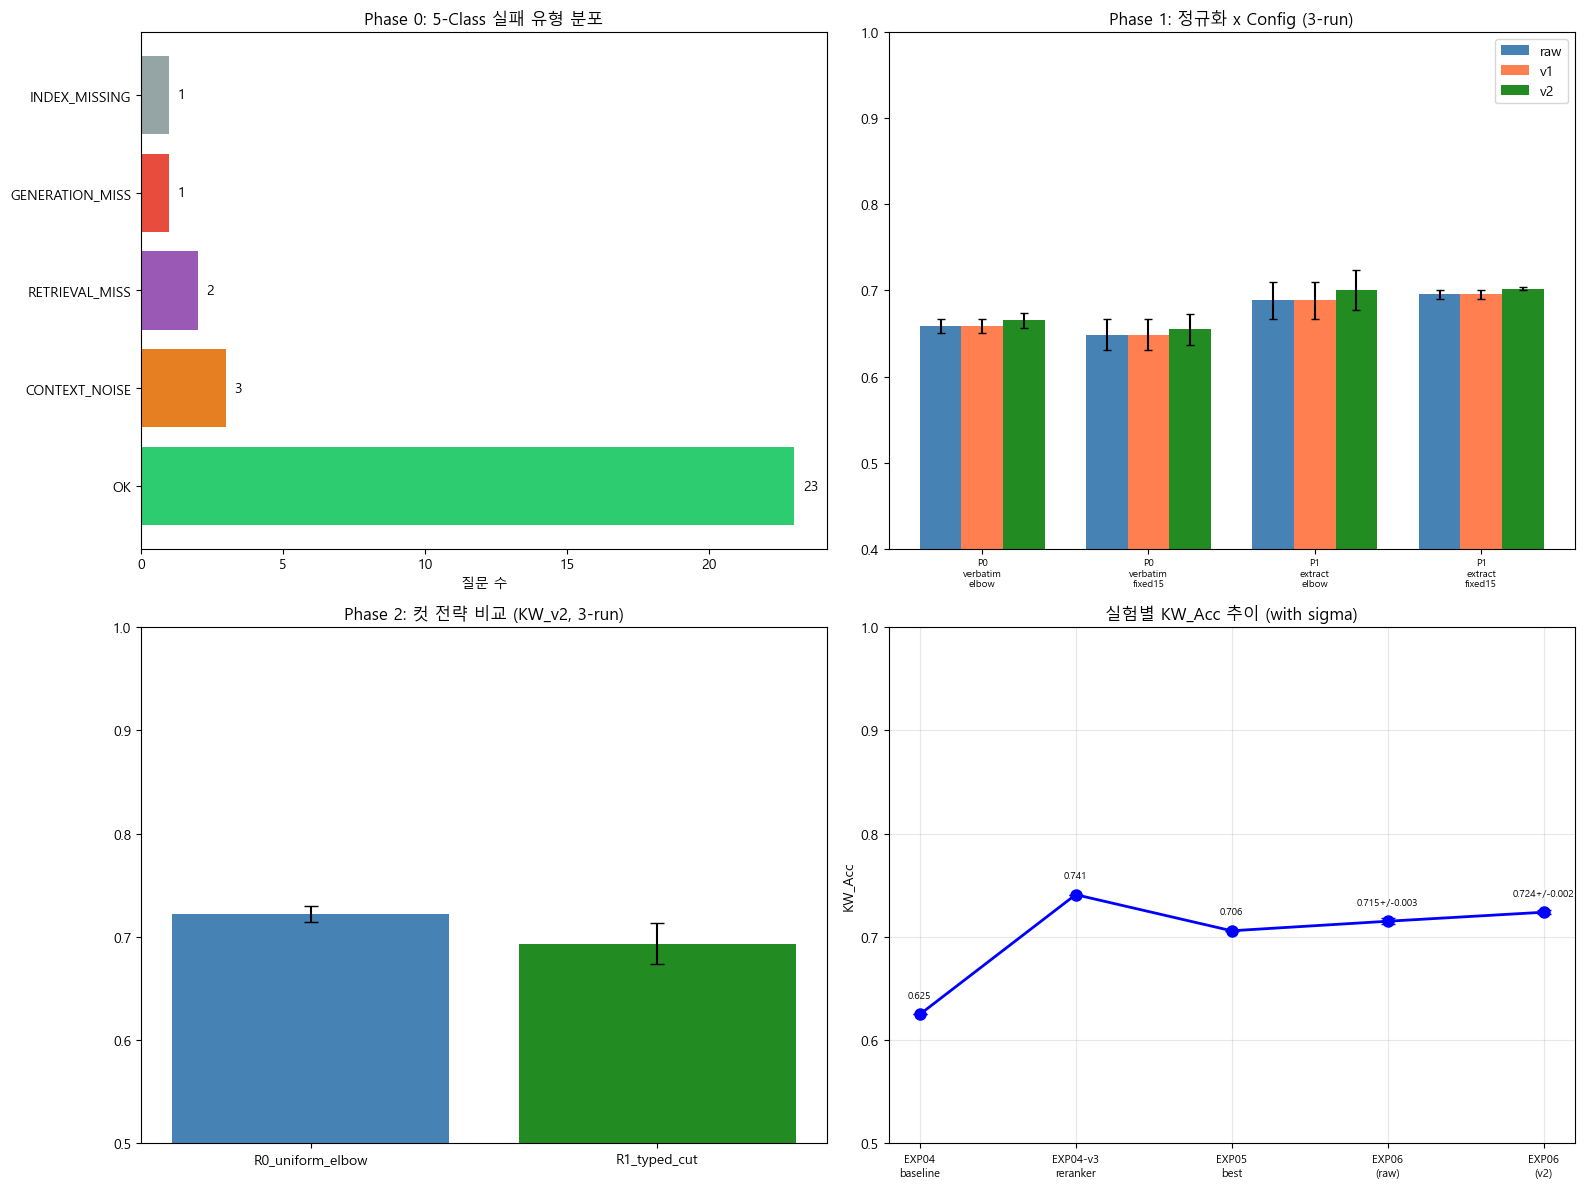

  Figure: ../data/experiments/exp06_results.png


In [17]:
# ============================================================
# 시각화
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Phase 0: 5-class 실패 유형
ax1 = axes[0][0]
fr_viz = pd.DataFrame(forensic_results)
ft_counts = fr_viz['failure_type'].value_counts()
cmap = {'OK': '#2ecc71', 'CONTEXT_NOISE': '#e67e22', 'GENERATION_MISS': '#e74c3c',
        'RERANK_MISS': '#f39c12', 'RETRIEVAL_MISS': '#9b59b6', 'INDEX_MISSING': '#95a5a6'}
ax1.barh(ft_counts.index, ft_counts.values,
         color=[cmap.get(ft, 'gray') for ft in ft_counts.index])
ax1.set_xlabel('질문 수')
ax1.set_title('Phase 0: 5-Class 실패 유형 분포')
for i, (ft, cnt) in enumerate(ft_counts.items()):
    ax1.text(cnt + 0.3, i, str(cnt), va='center')

# 2. Phase 1: 정규화 효과
ax2 = axes[0][1]
configs_short = [s['config'].replace('_', '\n') for s in phase1_summary]
x = np.arange(len(configs_short))
w = 0.25
ax2.bar(x - w, [s['kw_acc_mean'] for s in phase1_summary], w, label='raw',
        color='steelblue', yerr=[s['kw_acc_std'] for s in phase1_summary], capsize=3)
ax2.bar(x, [s['kw_v1_mean'] for s in phase1_summary], w, label='v1',
        color='coral', yerr=[s['kw_v1_std'] for s in phase1_summary], capsize=3)
ax2.bar(x + w, [s['kw_v2_mean'] for s in phase1_summary], w, label='v2',
        color='forestgreen', yerr=[s['kw_v2_std'] for s in phase1_summary], capsize=3)
ax2.set_xticks(x); ax2.set_xticklabels(configs_short, fontsize=7)
ax2.set_title('Phase 1: 정규화 x Config (3-run)'); ax2.legend(); ax2.set_ylim(0.4, 1.0)

# 3. Phase 2: 유형별 컷
ax3 = axes[1][0]
p2_names = [s['config'] for s in phase2_summary]
p2_kw = [s['kw_v2_mean'] for s in phase2_summary]
p2_err = [s['kw_v2_std'] for s in phase2_summary]
ax3.bar(p2_names, p2_kw, yerr=p2_err, capsize=5, color=['steelblue', 'forestgreen'])
ax3.set_title('Phase 2: 컷 전략 비교 (KW_v2, 3-run)'); ax3.set_ylim(0.5, 1.0)

# 4. 실험 진행 추이
ax4 = axes[1][1]
history = [
    ('EXP04\nbaseline', 0.625, 0),
    ('EXP04-v3\nreranker', 0.741, 0),
    ('EXP05\nbest', 0.706, 0),
    ('EXP06\n(raw)', np.mean(kw_raw_runs), np.std(kw_raw_runs)),
    ('EXP06\n(v2)', np.mean(kw_v2_runs), np.std(kw_v2_runs)),
]
xs = range(len(history))
ys = [h[1] for h in history]
errs = [h[2] for h in history]
ax4.errorbar(xs, ys, yerr=errs, fmt='bo-', linewidth=2, markersize=8, capsize=5)
ax4.set_xticks(list(xs)); ax4.set_xticklabels([h[0] for h in history], fontsize=8)
ax4.set_ylabel('KW_Acc'); ax4.set_title('실험별 KW_Acc 추이 (with sigma)')
ax4.grid(True, alpha=0.3); ax4.set_ylim(0.5, 1.0)
for i, h in enumerate(history):
    label = f'{h[1]:.3f}' if h[2] == 0 else f'{h[1]:.3f}+/-{h[2]:.3f}'
    ax4.annotate(label, (i, h[1]), textcoords='offset points', xytext=(0,12), ha='center', fontsize=7)

plt.tight_layout()
plt.savefig(OUT_FIG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'  Figure: {OUT_FIG_PATH}')

---
## 결론

### 핵심 발견: 병목은 "정규화/컷 전략"이 아니라 "테이블 파싱 품질"이다

- **table 질문 KW_v2 = 0.566 vs text 질문 KW_v2 = 0.780** (격차 21.4%p)
- 정규화 v2, 프롬프트 개선, 컷 전략 모두 text 질문에서는 효과적이나 table 질문의 근본적 한계를 돌파하지 못함
- 현재 마크다운 파이프 변환 방식이 **구조 정보(헤더-셀 관계, 병합 셀, 계층, caption/주석)**를 손실시키는 것이 원인
- 테이블은 텍스트와 달리 구조(structural information)가 의미의 절반 — 이 구조 손실이 검색/생성 튜닝만으로 해결 불가능한 이유

### Phase별 결과 요약

| Phase | 핵심 결론 | 영향도 |
|-------|----------|--------|
| **Phase 0 (5-Class 포렌식)** | CONTEXT_NOISE 3건 신규 발견. EXP05의 GEN_MISS 6건 중 3건을 재분류 | 진단 정밀화 |
| **Phase 1 (정규화 x Config)** | P1_extract + 정규화 v2 조합이 최적. v2는 모든 config에서 +0.6~1.2%p 일관 개선 | 중간 (+0.66~1.21%p) |
| **Phase 2 (Typed-Cut)** | typed-cut 가설 기각. 균일 elbow가 +2.9%p 우위 — context 양 조절은 주 병목 아님 | 낮음 (가설 기각) |
| **Phase 3 (통합 검증)** | 3-run 평균: KW_v2=0.724, Faith=0.894, CR=0.850. 4개 목표 모두 미달 | 최종 확인 |

> **3-run 평균화 프로토콜의 가치**: EXP04-v3의 KW_Acc 0.741은 단일 실행 결과였으며, 3-run 수렴값 0.715와 비교하면 +2.6%p의 측정 변동이 존재한다. 이전 실험들의 단일 실행 결과를 직접 비교하는 것은 주의가 필요하다.

### 일관 실패 질문 — EXP07 처방 매핑

| 질문 | 유형 | KW_Acc | EXP07 처방 |
|------|------|--------|----------|
| Q3 (기술능력/입찰가격 배점 비율) | INDEX_MISSING | 0.250 | JSON 재파싱 후 Oracle=1.0 도달 여부가 **1번 KPI** |
| Q9 (사업예산 총액/부가세) | CONTEXT_NOISE | 0.333 | row/cell-level 검색으로 불필요 테이블 덩어리 유입 차단 |
| Q23 (인증 방식) | CONTEXT_NOISE | 0.091 | row/cell-level 검색 + table-level caption/notes 보강 |
| Q10 (연도별 사업비 지급 비율) | RETRIEVAL_MISS | 0.111 | 다중 쿼리(연도별+지급비율+사업비)로 row 교집합 구성 |
| Q5 (하자보수 기간) | RETRIEVAL_MISS | 0.167 | 쿼리 확장(query expansion) |

→ 5건 중 4건(Q3, Q9, Q10, Q23)이 **테이블 저장/검색 단위 재설계**로 개선 기대

### 다음 실험(EXP07) 방향: "JSON 전환"이 아니라 "Table-aware RAG"

JSON 형식 전환 자체보다 **"테이블을 어떤 단위로 저장/검색/추출할지"**를 같이 설계해야 실제 성능이 오른다.

**1. 2레벨 JSON 스키마 설계 (1순위)**

(A) **Table-level 문서** — 전역 컨텍스트 보존:
- `table_id`, `caption/title`, `notes`(단위, 부가세 포함 여부 등), `header_tree`, `page`, `section_path`

(B) **Row/Cell-level 문서** — 정밀 검색 단위:
- row: `table_id`, `row_key`(연도/구분), `cells{col_path: value}`, `page`
- cell(필요 시): `table_id`, `row_key`, `col_path`, `value`, `page`

→ 검색은 row/cell로 정확히 걸고, 생성/추출은 table-level의 caption/notes까지 붙여서 단위/부가세 등의 실수를 줄임

**2. HTML 원형 병행 보관 (하이브리드 전략)**

단순 key-value JSON만으로는 표 제목·주석·그룹핑이 사라질 위험이 있음.
- **Canonical JSON**(검색/추출용): row/cell 키-값 + 헤더 경로 + caption/notes
- **HTML table**(검증/디버깅용): 병합셀·행열 관계·다중 헤더 원형 보존

**3. 테이블 질문 라우팅 파이프라인**

```
질문 → 테이블 질문 감지(규칙 기반) → row/cell 인덱스 top-N
     → table_id로 묶어 table-level 문서 1~2개 보강
     → reranker(현행 유지) → 값 추출 중심 프롬프트
```

> 표 기반 QA는 "자연어 생성"보다 "구조화된 데이터에서 정확히 뽑기"에 가까움. 생성(요약)이 아닌 추출(값 특정) 관점으로 프롬프트를 설계해야 한다.

**4. 실험 Config**

| Config | 설명 |
|--------|------|
| T0_current | 현행 (마크다운 테이블 텍스트 인덱스) |
| T1_table_json | 테이블을 JSON(table + row/cell 2레벨)으로 재구성, 별도 인덱스 |

**성공 KPI**: table 질문 Oracle/Recall@K 격차가 줄었는지를 최우선으로 측정

**5. 평가 체계 보완**

- **(유지)** KW_Acc(정규화 v2): 기존 비교 기준 유지
- **(보완)** Semantic similarity: 임베딩 기반 (숫자/단위는 별도 처리)
- **(보완)** LLM-as-Judge: "근거와 정합한가 / 값이 맞는가" 분리 평가, 최소 3회 평균 + 고정 프롬프트